# Image Quality Evaluations of XCIST

The purpose of this is to validate the image quality of the XCIST simulator based on the IEC61223-3-5 for acceptance testing, these testes include:

| PROTOCOL ELEMENT | MEAN CT NUMBER                       | NOISE                                               | UNIFORMITY             |
|------------------|--------------------------------------|-----------------------------------------------------|------------------------|
| Adult Head       | Nominal value ± 4 HU (Small PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Small PHANTOM) | ≤ 4 HU (Small PHANTOM) |
| Adult Body       | Nominal value ± 6 HU (Large PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Large PHANTOM) | ≤ 8 HU (Large PHANTOM) |
| Paediatric Head  | Nominal value ± 4 HU (Small PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Small PHANTOM) | ≤ 4 HU (Small PHANTOM) |
| Paediatric Body  | Nominal value ± 4 HU (Small PHANTOM) | Nominal value ± max (15 %; 0,75 HU) (Small PHANTOM) | ≤ 4 HU (Small PHANTOM) |

Spatial Resolution, Artifacts, CTDI

In [1]:
!ls /gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms/CTP404/diameter_350mm/

350mm_CTP404_groundtruth.dcm  350mm_CTP404_noisefree.dcm  dose_025  dose_100


In [2]:
import pydicom
import numpy as np

def read_dicom(dcm):
    assert(isinstance(dcm, pydicom.dataset.FileDataset))
    return dcm.pixel_array + dcm.RescaleIntercept
dcm = pydicom.read_file('/gpfs_projects/brandon.nelson/RSTs/pediatricIQphantoms/CTP404/diameter_350mm/350mm_CTP404_groundtruth.dcm')
phantom = read_dicom(dcm)
phantom = np.repeat(phantom[None], 200, axis=0)
phantom.shape

(200, 512, 512)

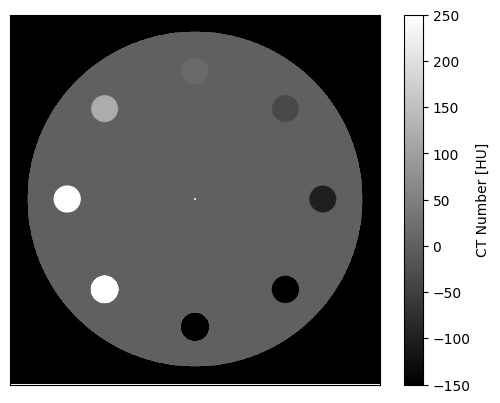

In [3]:
import matplotlib.pyplot as plt
from utils import ctshow, scrollview
im = ctshow(phantom)
plt.colorbar(im, label='CT Number [HU]')

In [4]:
from utils import CTobj

In [5]:
from dxcist.xcist_sims import get_effective_diameter

In [6]:
diameter_pixels = get_effective_diameter(phantom[0], 1)
known_diameter_mm = 200
fov_mm = phantom.shape[-1]*known_diameter_mm/diameter_pixels
fov_mm
dx = fov_mm/phantom.shape[-1]
dx

0.4301413648682815

In [7]:
ct = CTobj(phantom, spacings=3*[dx], patientname='CTP404')

Initializing Scanner object...
----------
*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.4301413648682815-mm pixels (XY), 0.4301413648682815-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['ICRU_lung_adult_healthy', 'ICRU_adipose_adult2', 'water', 'ICRU_liver_adult', 'ICRU_skeleton_cortical_bone_adult']
* mu values (/cm): [0.05, 0.19, 0.21, 0.22, 0.6]
* mu(water) (/cm): 0.21
* Thresholds (/cm): [0.0, 0.16, 0.21, 0.23, 0.27]
* Thresholds (HU): [-1000.0, -200.0, 0.0, 100.0, 300.0]
*********************************************
* Calculating volume fraction maps for 5 materials and 200 slices...
* Writing volume fra

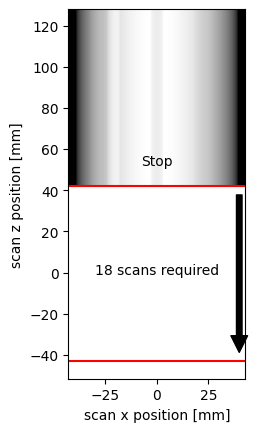

In [8]:
ct.scout_view()

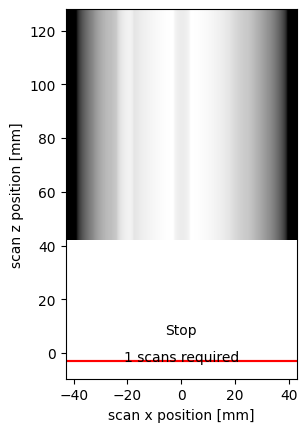

In [9]:
ct.scout_view(startZ=-5, endZ=1)

In [ ]:
ct.run_scan(startZ=-5, endZ=1, views=1000)

scan: 1/1
Airscan
Offset scan
Phantom scan
phantom scan view loop...


  0%|                                                                                                                                                      | 0/1000 [00:00<?, ?it/s]

in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated memory for image volume for material  5
in C> Copying data for material  5 into C memory...in C>  done.
in C> Allocated a total of   1000 MB.


  4%|█████▋                                                                                                                                       | 40/1000 [01:42<32:10,  2.01s/it]

In [ ]:
ct.run_recon(fov=fov_mm)

In [ ]:
ctshow(np.concatenate([ct.phantom[0], ct.recon[0]], axis=1))

In [ ]:
scrollview(ct.recon)

In [ ]:
ct.xcist.protocol.mA